In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import torch
import pandas as pd # Using pandas for easier data handling and plotting

import mlmodel_encoder

# filename = '/home/rohan/adaptive_reachability/quadrotor_dynamics_3000.pkl' # Or 'quadrotor_dynamics_data.pkl' if you used the first script
filename = "/home/rohan/adaptive_reachability/quadrotor_dynamics_3000_2_5_increased_winds.pkl"
# filename = 'quadrotor_dynamics_data_z_pid.pkl' # Or 'quadrotor_dynamics_data.pkl' if you used the first script

filepath = os.path.join(os.getcwd(), filename)

data_dictionary = None
try:
    with open(filepath, 'rb') as f:
        data_dictionary = pickle.load(f)
    print(f"Successfully loaded data from '{filename}'.")
except FileNotFoundError:
    print(f"Error: Data file not found at '{filepath}'.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

if data_dictionary:
    print("Keys in the data dictionary:", data_dictionary.keys())
    print("\nMetadata:")
    for key, value in data_dictionary.get('metadata', {}).items():
        print(f"  {key}: {value}")

    print("\nData Shapes:")
    print(f"  Velocities (v): {data_dictionary.get('velocities', np.array([])).shape}")
    print(f"  Winds (w): {data_dictionary.get('winds', np.array([])).shape}")
    print(f"  Controls (u): {data_dictionary.get('controls', np.array([])).shape}")
    print(f"  Accelerations (a): {data_dictionary.get('accelerations', np.array([])).shape}")

Successfully loaded data from '/home/rohan/adaptive_reachability/quadrotor_dynamics_3000_2_5_increased_winds.pkl'.
Keys in the data dictionary: dict_keys(['velocities', 'winds', 'controls', 'accelerations', 'quaternions', 'metadata'])

Metadata:
  description: Dataset for learning control-affine quadrotor linear dynamics a = f(v, w) + g(v)u with Z-PID control for altitude and sampled attitude commands
  num_runs: 3000
  steps_per_run: 2000
  total_data_points_attempted: 6000000
  attitude_hold_steps: 50
  initial_velocity_bounds: [[-2.   2. ]
 [-2.   2. ]
 [-0.1  0.1]]
  wind_bounds: [[-2.5   2.5 ]
 [-2.5   2.5 ]
 [-0.02  0.02]]
  attitude_control_bounds: [[-0.25  0.25]
 [-0.25  0.25]]
  z_pid_gains: {'Kp_z': 1.0, 'Ki_z': 0.1, 'Kd_z': 1.5}
  target_z: 2
  sim_timestep: 0.01
  vehicle_params: {'mass': 0.03, 'Ixx': 1.43e-05, 'Iyy': 1.43e-05, 'Izz': 2.89e-05, 'Ixy': 0.0, 'Iyz': 0.0, 'Ixz': 0.0, 'num_rotors': 4, 'rotor_pos': {'r1': array([0.03040559, 0.03040559, 0.        ]), 'r2': array([

In [2]:
# Model = mlmodel_encoder.load_model('run_3_encoder30.pth', '../models_encoders/')
Model = mlmodel_encoder.load_model('run_4_encoder_increased_wind30.pth', '../models_encoders/')

/home/rohan/adaptive_reachability/dynamics_learning_encoder/mlmodel_encoder.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path + modelna

In [3]:
wind_high_positive = (Model.mu(torch.tensor([2.5, 2.5])))
wind_high_negative = (Model.mu(torch.tensor([-2.5, 0.0])))
wind_zero = (Model.mu(torch.tensor([0.0, 0.0])))
velocity = torch.tensor([0.0, 0.0])
print(wind_high_positive)
print(wind_high_negative)
print(wind_zero)

# Now compute f(v, w) for different wind values, keeping velocity at zero
# Note: The model expects a batch dimension, so we add it using unsqueeze(0)
f_high_positive = Model.f(torch.cat([velocity, wind_high_positive]))
f_high_neg = Model.f(torch.cat([velocity, wind_high_negative]))
f_zero = Model.f(torch.cat([velocity, wind_zero]))
print(f"f_zero: {f_zero}")
print(f"f_high_positive: {f_high_positive}")
print(f"f_high_neg: {f_high_neg}")

tensor([ 3.5152, -4.5873], grad_fn=<ViewBackward0>)
tensor([0.2491, 0.2145], grad_fn=<ViewBackward0>)
tensor([ 0.5693, -2.2985], grad_fn=<ViewBackward0>)
f_zero: tensor([-0.0044, -0.0100], grad_fn=<ViewBackward0>)
f_high_positive: tensor([1.4685, 1.3500], grad_fn=<ViewBackward0>)
f_high_neg: tensor([-0.8219,  0.0259], grad_fn=<ViewBackward0>)


In [4]:
print(wind_zero.detach().numpy())
print(wind_zero.device)

[ 0.5693139 -2.2985244]
cpu


-1.2128137 min_z1
3.4791784 max_z1
-6.516053 min_z2
0.64371413 max_z2
Point (1.5, 0.0) is inside the rectangle.


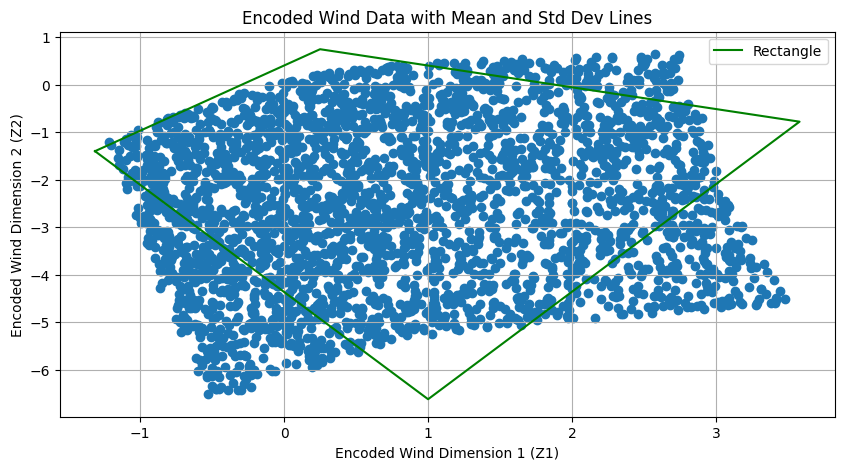

In [ ]:
# Get all wind data
all_wind_data = data_dictionary['winds'][::2000, :2]  # Use only the first two dimensions

# Convert to torch tensor
all_wind_data_torch = torch.tensor(all_wind_data).float()

# Encode the wind data
encoded_wind = Model.mu(all_wind_data_torch).detach().numpy()

# plt.figure(figsize=(10, 5))
# plt.scatter(all_wind_data[:, 0], all_wind_data[:, 1])
print(np.min(encoded_wind[:,0]), 'min_z1')
print(np.max(encoded_wind[:,0]), 'max_z1')
print(np.min(encoded_wind[:,1]), 'min_z2')
print(np.max(encoded_wind[:,1]), 'max_z2')
# Plotting the distribution
plt.figure(figsize=(10, 5))
plt.scatter(encoded_wind[:, 0], encoded_wind[:, 1])

"""
These are points for the rectangle_run_3
"""
point_1 = [np.min(encoded_wind[:, 0]), -1.4]  # Mean of encoded wind
point_2 = [1.0, np.min(encoded_wind[:, 1])-0.1]
point_3 = [np.max(encoded_wind[:, 0])+0.1, -0.78]
point_4 = [0.25, np.max(encoded_wind[:, 1])+0.1]

"""
Points for the rectangle_run_4 increased winds
"""


# Define the four corners of the rectangle
# Extract x and y values for the rectangle
x_rect = [point_1[0], point_2[0], point_3[0], point_4[0], point_1[0]]
y_rect = [point_1[1], point_2[1], point_3[1], point_4[1], point_1[1]]
def is_point_inside_rectangle(point, rect_points):
    """
    Check if a point is inside a rectangle defined by its vertices.

    Args:
        point (tuple): A tuple (x, y) representing the point.
        rect_points (list): A list of tuples [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
                           representing the vertices of the rectangle in order.

    Returns:
        bool: True if the point is inside the rectangle, False otherwise.
    """
    x, y = point
    x1, y1 = rect_points[0]
    x2, y2 = rect_points[1]
    x3, y3 = rect_points[2]
    x4, y4 = rect_points[3]

    # Calculate the areas of the four triangles formed by the point and the rectangle's sides
    area1 = 0.5 * abs((x2 - x1) * (y - y1) - (x - x1) * (y2 - y1))
    area2 = 0.5 * abs((x3 - x2) * (y - y2) - (x - x2) * (y3 - y2))
    area3 = 0.5 * abs((x4 - x3) * (y - y3) - (x - x3) * (y4 - y3))
    area4 = 0.5 * abs((x1 - x4) * (y - y4) - (x - x4) * (y1 - y4))

    # Calculate the area of the rectangle
    rect_area = 0.5 * abs((x2 - x4) * (y3 - y1) - (x3 - x1) * (y2- y4))

    # Check if the sum of the triangle areas is equal to the rectangle's area
    return abs(area1 + area2 + area3 + area4 - rect_area) < 1e-6  # Using a small tolerance for floating-point comparisons
rect_points = [point_1, point_2, point_3, point_4]
# Example usage:
point = (1.5, 0.0)
if is_point_inside_rectangle(point, rect_points):
    print(f"Point {point} is inside the rectangle.")
else:
    print(f"Point {point} is outside the rectangle.")
# Plot the rectangle
plt.plot(x_rect, y_rect, color='green', linestyle='-', label='Rectangle')

# Plot the line
plt.xlabel("Encoded Wind Dimension 1 (Z1)")
plt.ylabel("Encoded Wind Dimension 2 (Z2)")
plt.title("Encoded Wind Data with Mean and Std Dev Lines")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

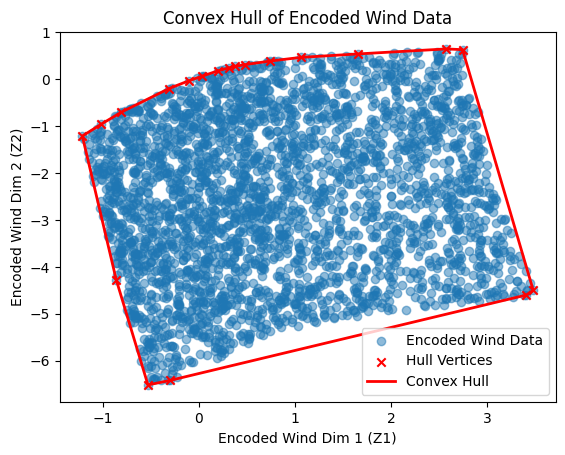

In [17]:
"""
Convex hull of the points
"""
from scipy.spatial import ConvexHull
hull_encoded_points = ConvexHull(encoded_wind)

hull_vertices = encoded_wind[hull_encoded_points.vertices]
# Plot all encoded wind points
plt.scatter(encoded_wind[:, 0], encoded_wind[:, 1], label='Encoded Wind Data', alpha=0.5)

# Mark the hull vertices
plt.scatter(hull_vertices[:, 0], hull_vertices[:, 1], color='red', marker='x', label='Hull Vertices')

# Draw lines between consecutive hull vertices and close the loop
hull_loop = np.vstack([hull_vertices, hull_vertices[0]])
plt.plot(hull_loop[:, 0], hull_loop[:, 1], 'r-', linewidth=2, label='Convex Hull')

plt.xlabel("Encoded Wind Dim 1 (Z1)")
plt.ylabel("Encoded Wind Dim 2 (Z2)")
plt.title("Convex Hull of Encoded Wind Data")
plt.legend()
plt.show()

In [19]:
print("np.array(" + repr(hull_vertices.tolist()) + ", dtype=np.float32)")

np.array([[3.4791784286499023, -4.5007829666137695], [2.743741273880005, 0.628009557723999], [2.573221445083618, 0.6437141299247742], [1.6516869068145752, 0.5366067886352539], [1.0603339672088623, 0.4633553624153137], [0.7437411546707153, 0.3856971859931946], [0.48283955454826355, 0.31055355072021484], [0.37844324111938477, 0.27258390188217163], [0.31022727489471436, 0.23910009860992432], [0.199270099401474, 0.17853683233261108], [0.03084227442741394, 0.06053364276885986], [-0.10589760541915894, -0.03596244752407074], [-0.3110600411891937, -0.20047420263290405], [-0.8068870306015015, -0.7040780782699585], [-1.0140106678009033, -0.9574630856513977], [-1.2128137350082397, -1.2127680778503418], [-0.8596087694168091, -4.277717590332031], [-0.5296590328216553, -6.516053199768066], [-0.29882803559303284, -6.419864654541016], [3.40598201751709, -4.600447654724121]], dtype=np.float32)


In [20]:
vertices = np.array([[3.4791784286499023, -4.5007829666137695], [2.743741273880005, 0.628009557723999], [2.573221445083618, 0.6437141299247742], [1.6516869068145752, 0.5366067886352539], [1.0603339672088623, 0.4633553624153137], [0.7437411546707153, 0.3856971859931946], [0.48283955454826355, 0.31055355072021484], [0.37844324111938477, 0.27258390188217163], [0.31022727489471436, 0.23910009860992432], [0.199270099401474, 0.17853683233261108], [0.03084227442741394, 0.06053364276885986], [-0.10589760541915894, -0.03596244752407074], [-0.3110600411891937, -0.20047420263290405], [-0.8068870306015015, -0.7040780782699585], [-1.0140106678009033, -0.9574630856513977], [-1.2128137350082397, -1.2127680778503418], [-0.8596087694168091, -4.277717590332031], [-0.5296590328216553, -6.516053199768066], [-0.29882803559303284, -6.419864654541016], [3.40598201751709, -4.600447654724121]], dtype=np.float32)

print(vertices.shape)

(20, 2)


In [22]:
print(hull_encoded_points.equations.shape)

(20, 3)


In [103]:
rectangle_points = [[np.float32(-1.3816031), 1.7], [1.4, np.float32(2.2500803)], [np.float32(2.2500803), 0.4], [-0.3, np.float32(-0.2839059)]]
print(is_point_inside_rectangle([0.0, -0.1], rectangle_points))

True


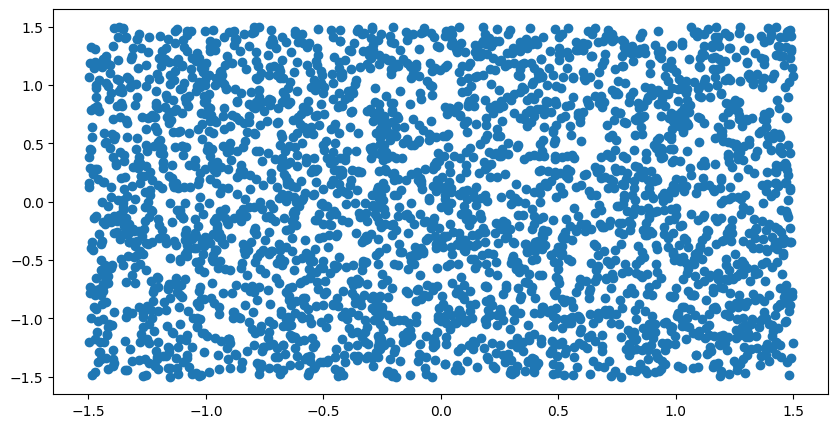

In [104]:
plt.figure(figsize=(10, 5))
plt.scatter(all_wind_data[:, 0], all_wind_data[:, 1])

In [5]:
def inference(model, velocity_data, control_data, wind_data):
    ## they are all numpy.ndarray
    # Add batch dimension if not present (assuming inference works on batches)
    diff = []
    if velocity_data.ndim == 1:
        velocity_data = velocity_data[np.newaxis, :]
    if control_data.ndim == 1:
         control_data = control_data[np.newaxis, :]
    if wind_data.ndim == 1:
         wind_data = wind_data[np.newaxis, :]
    # Handle acc_data being None for inference calls

    velocity_data_t = torch.tensor(velocity_data[..., :2]).to(torch.float32)
    control_data_t = torch.tensor(control_data[..., :2]).to(torch.float32)
    wind_data_t = torch.tensor(wind_data[..., :2]).to(torch.float32)
    no_wind_data_t = torch.zeros_like(wind_data_t)

    with torch.no_grad():
        # Ensure inputs match expected dimensions for concatenation if necessary
        # Assuming velocity, wind are the same dimension for f
        f_input = torch.cat([velocity_data_t, model.mu(wind_data_t)], dim=-1)
        f_output = model.f(f_input)

        f_input_no_wind = torch.cat([velocity_data_t, model.mu(no_wind_data_t)], dim=-1)
        f_output_no_wind = model.f(f_input_no_wind)
        print(f_output - f_output_no_wind)
        g_output_matrix = model.g(velocity_data_t).reshape(f_output.shape[0], 2, 2)
        g_output = torch.matmul(g_output_matrix, control_data_t.unsqueeze(-1)).squeeze(-1) # Result shape [B, 3]

    predicted_acceleration = (f_output + g_output).numpy()
    predicted_acceleration_no_wind = (f_output_no_wind + g_output).numpy()

    if predicted_acceleration.shape[0] == 1:
        predicted_acceleration = predicted_acceleration.squeeze(0)
        predicted_acceleration_no_wind = predicted_acceleration_no_wind.squeeze(0)
    return predicted_acceleration, predicted_acceleration_no_wind


In [6]:
def predict_acceleration_learned_wind(velocity, control, wind, model):
    predicted_acc, _ = inference(model, velocity, control, wind)
    return predicted_acc 

def predict_acceleration_learned_no_wind(velocity, control, wind, model):
     # acc_data is not used in inference for prediction, pass None or dummy
    _, predicted_acc_no_wind = inference(model, velocity, control, wind)
    return predicted_acc_no_wind # This should be a numpy array (3,)

def predict_acceleration_nominal(velocity, control, wind, model):
    # The nominal model calculation from your plot
    nominal_accel_x = 9.8 * np.tan(control[0])
    nominal_accel_y = -9.8 * np.tan(control[1])
    nominal_accel_z = control[2] - 9.81
    # Assuming y and z acceleration are zero for the nominal case
    nominal_accel = np.array([nominal_accel_x, nominal_accel_y, nominal_accel_z])
    return nominal_accel # This should be a numpy array (3,)

In [7]:
def perform_rollout(initial_velocity, control_data, wind_data, predict_accel_fn, delta_t, model):
    """
    Performs a rollout simulation using a given acceleration prediction function.

    Args:
        initial_velocity (np.ndarray): The starting velocity (shape 3,).
        control_data (np.ndarray): Array of control inputs over time (shape N, n_controls).
        wind_data (np.ndarray): Array of wind inputs over time (shape N, 3).
        predict_accel_fn (function): A function that takes (velocity, control, wind, **kwargs)
                                     and returns a numpy array acceleration (shape 3,).
        delta_t (float): The time step for integration.
        **predict_accel_kwargs: Additional keyword arguments to pass to predict_accel_fn
                                (e.g., the neural network model).

    Returns:
        np.ndarray: Array of predicted velocities over time (shape N+1, 3).
    """
    num_steps = control_data.shape[0]
    # predicted_velocities = np.zeros((num_steps + 1, 3))
    predicted_velocities = np.zeros_like(control_data)
    # predicted_positions = np.zeros((num_steps + 1, 3))
    predicted_positions = np.zeros_like(control_data)
    predicted_velocities[0, :] = initial_velocity
    current_velocity = initial_velocity.copy()
    
    for i in range(num_steps-1):
        control = control_data[i, :]
        wind = wind_data[i, :]

        acceleration = predict_accel_fn(current_velocity, control, wind, model)
        current_velocity = current_velocity + acceleration * delta_t
        predicted_velocities[i + 1, :] = current_velocity
        predicted_positions[i+1, :] = predicted_positions[i, :] + delta_t * current_velocity

    return predicted_velocities, predicted_positions

def perform_rollout_actual(velocity_data, delta_t=0.01):
    actual_position = np.zeros_like(velocity_data)

    for i in range(1, velocity_data.shape[0]):
        actual_position[i, :] = actual_position[i-1, :] + delta_t * velocity_data[i, :]
    return actual_position

tensor([[1.5045, 1.1771]])
tensor([[1.5043, 1.1770]])
tensor([[1.5041, 1.1769]])
tensor([[1.5040, 1.1767]])
tensor([[1.5038, 1.1766]])
tensor([[1.5036, 1.1764]])
tensor([[1.5034, 1.1763]])
tensor([[1.5032, 1.1762]])
tensor([[1.5030, 1.1760]])
tensor([[1.5029, 1.1759]])
tensor([[1.5027, 1.1758]])
tensor([[1.5025, 1.1757]])
tensor([[1.5023, 1.1755]])
tensor([[1.5022, 1.1754]])
tensor([[1.5020, 1.1753]])
tensor([[1.5018, 1.1752]])
tensor([[1.5017, 1.1751]])
tensor([[1.5015, 1.1749]])
tensor([[1.5014, 1.1748]])
tensor([[1.4971, 1.1713]])
tensor([[1.4903, 1.1655]])
tensor([[1.4835, 1.1598]])
tensor([[1.4767, 1.1542]])
tensor([[1.4700, 1.1486]])
tensor([[1.4634, 1.1430]])
tensor([[1.4567, 1.1375]])
tensor([[1.4502, 1.1320]])
tensor([[1.4437, 1.1265]])
tensor([[1.4372, 1.1211]])
tensor([[1.4308, 1.1157]])
tensor([[1.4244, 1.1104]])
tensor([[1.4180, 1.1051]])
tensor([[1.4117, 1.0998]])
tensor([[1.4055, 1.0946]])
tensor([[1.3993, 1.0894]])
tensor([[1.3931, 1.0842]])
tensor([[1.3870, 1.0791]])
t

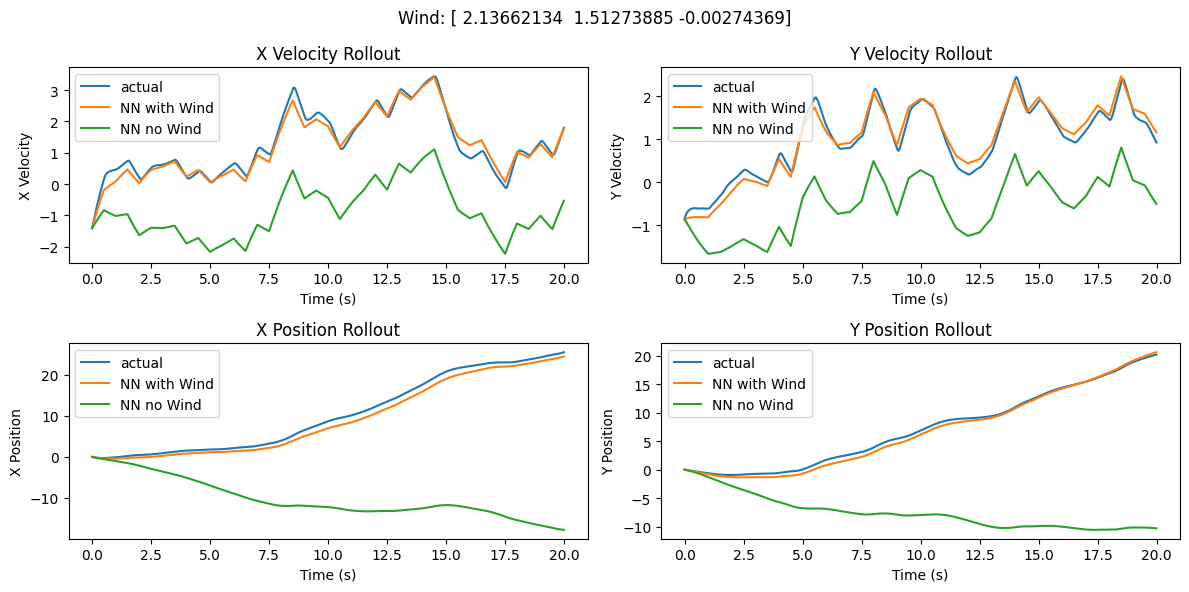

In [8]:
starting_index = 112 * 2000
nominal_velocity_rollout, nominal_position_rollout = perform_rollout(
    initial_velocity=data_dictionary['velocities'][starting_index],
    control_data=data_dictionary['controls'][starting_index:starting_index + 2000],
    wind_data=data_dictionary['winds'][starting_index:starting_index + 2000],
    predict_accel_fn=predict_acceleration_nominal,
    delta_t=data_dictionary['metadata']['sim_timestep'],
    model = Model
)
NN_wind_velocity_rollout, NN_wind_position_rollout = perform_rollout(
    initial_velocity=data_dictionary['velocities'][starting_index, :2],
    control_data=data_dictionary['controls'][starting_index:starting_index + 2000, :2],
    wind_data=data_dictionary['winds'][starting_index:starting_index + 2000, :2],
    predict_accel_fn=predict_acceleration_learned_wind,
    delta_t=data_dictionary['metadata']['sim_timestep'],
    model = Model
)
NN_no_wind_velocity_rollout, NN_no_wind_position_rollout = perform_rollout(
    initial_velocity=data_dictionary['velocities'][starting_index, :2],
    control_data=data_dictionary['controls'][starting_index:starting_index + 2000, :2],
    wind_data=data_dictionary['winds'][starting_index:starting_index + 2000, :2],
    predict_accel_fn=predict_acceleration_learned_no_wind,
    delta_t=data_dictionary['metadata']['sim_timestep'],
    model = Model
)
actual_position = perform_rollout_actual(data_dictionary['velocities'][starting_index:starting_index+2000])
wind = data_dictionary['winds'][starting_index]
time = np.arange(nominal_velocity_rollout.shape[0]) * data_dictionary['metadata']['sim_timestep']
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(time, data_dictionary['velocities'][starting_index:starting_index+2000, 0], label='actual')
# plt.plot(time, nominal_velocity_rollout[:, 0], label='Nominal')
plt.plot(time, NN_wind_velocity_rollout[:, 0], label='NN with Wind')
plt.plot(time, NN_no_wind_velocity_rollout[:, 0], label='NN no Wind')
plt.xlabel('Time (s)')
plt.ylabel('X Velocity')
plt.title('X Velocity Rollout')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(time, data_dictionary['velocities'][starting_index:starting_index+2000, 1], label='actual')
# plt.plot(time, nominal_velocity_rollout[:, 1], label='Nominal')
plt.plot(time, NN_wind_velocity_rollout[:, 1], label='NN with Wind')
plt.plot(time, NN_no_wind_velocity_rollout[:, 1], label='NN no Wind')
plt.xlabel('Time (s)')
plt.ylabel('Y Velocity')
plt.title('Y Velocity Rollout')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(time, actual_position[:,0], label='actual')
# plt.plot(time, nominal_position_rollout[:, 0], label='Nominal')
plt.plot(time, NN_wind_position_rollout[:, 0], label='NN with Wind')
plt.plot(time, NN_no_wind_position_rollout[:, 0], label='NN no Wind')
plt.xlabel('Time (s)')
plt.ylabel('X Position')
plt.title('X Position Rollout')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(time, actual_position[:,1], label='actual')
# plt.plot(time, nominal_position_rollout[:, 1], label='Nominal')
plt.plot(time, NN_wind_position_rollout[:, 1], label='NN with Wind')
plt.plot(time, NN_no_wind_position_rollout[:, 1], label='NN no Wind')
plt.xlabel('Time (s)')
plt.ylabel('Y Position')
plt.title('Y Position Rollout')
plt.legend()
plt.suptitle(f'Wind: {wind}')
plt.tight_layout()
plt.show()

tensor([[ 0.2051,  0.0017],
        [ 0.2051,  0.0017],
        [ 0.2051,  0.0017],
        ...,
        [ 0.1390, -0.0533],
        [ 0.1390, -0.0533],
        [ 0.1390, -0.0533]])
Mean Squared Error: 0.8772190483284872


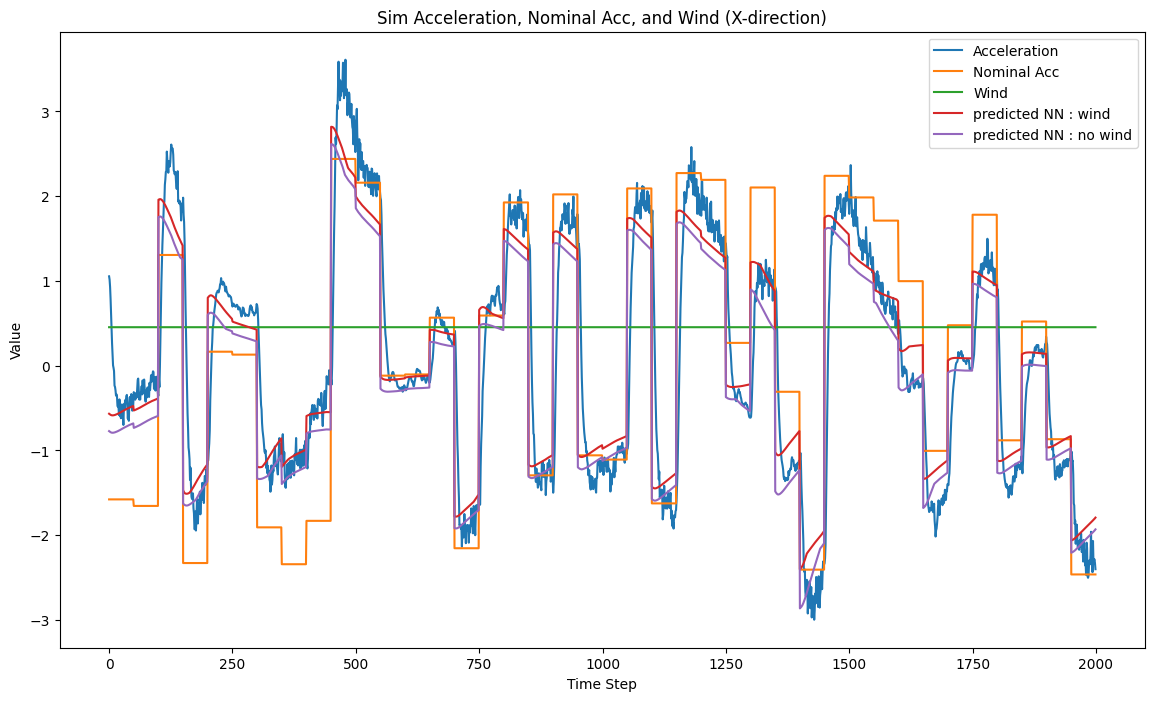

In [9]:
starting_index = 11 * 2000
actual_acceleration_data = data_dictionary['accelerations'][starting_index : starting_index + 2000]
actual_velocity_data = data_dictionary['velocities'][starting_index : starting_index + 2000]
wind_data = data_dictionary['winds'][starting_index : starting_index + 2000]
control_data = data_dictionary['controls'][starting_index : starting_index + 2000]

predicted_acc_NN_wind, predicted_acc_NN_no_wind = inference(Model, actual_velocity_data, control_data, wind_data)

plt.plot(actual_acceleration_data[:, 0])
plt.plot(9.8 * np.tan(data_dictionary['controls'][starting_index:starting_index+2000:, 0]))
plt.plot(data_dictionary['winds'][starting_index:starting_index+2000, 0])
plt.plot(predicted_acc_NN_wind[:, 0])
plt.plot(predicted_acc_NN_no_wind[:,0])
# Calculate Mean Squared Error
acceleration_data = data_dictionary['accelerations'][starting_index:starting_index+2000, 0]
control_data = 9.8 * np.tan(data_dictionary['controls'][starting_index:starting_index+2000:, 0])
mse = np.mean((acceleration_data - control_data)**2)
print(f"Mean Squared Error: {mse}")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Sim Acceleration, Nominal Acc, and Wind (X-direction)")
plt.legend(["Acceleration", "Nominal Acc", "Wind", "predicted NN : wind", "predicted NN : no wind"])
plt.gcf().set_size_inches(14, 8)
plt.show()